<a href="https://colab.research.google.com/github/jiswoo/CS114.L21.KHCL/blob/main/DuDoanDiem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><b>CS114.L21.KHCL - MÁY HỌC</b></h1>
<h1 align="center"><b>Bài tập dự đoán điểm cuối kì trên Wecode</b></h1>

**Thành viên**
- Huỳnh Đỗ Anh Vũ - 18521665 - 18521665@gm.uit.edu.vn
- Phan Khắc Cường	 - 18520548 - 18520548@gm.uit.edu.vn
- Đặng Trần Hồng Hà - 19520504 - 19520504@gm.uit.edu.vn

In [ ]:
# Tham khảo: 
# https://github.com/caohungphu/CS114.L21/blob/main/Colab/Predict_final_exam_score.ipynb
# https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Vẽ đồ thị
def drawPlotNormal(dataList):
  for data in dataList:
    x = data[0]
    y = data[1]
    y_label = data[2]
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set(xlabel=y_label, ylabel='CK')
    plt.scatter(x, y)
  plt.show()

# Nguồn: https://github.com/buidung2004/CS114.L21/blob/main/Assignment/26-04/Linear_Regession.ipynb
def drawPlot(x, y, model):
  plt.subplots(figsize=(10,10))
  plt.scatter(x, y)
  y_pred = np.array(model.predict(x))
  plt.scatter(x, y_pred)
  plt.show()

# Vẽ đồ thị với vector 4 chiều
def drawPlot4Dimension(x, x4Dim, y, model):
  plt.subplots(figsize=(10,10))
  plt.scatter(x, y)
  y_pred = np.array(model.predict(x4Dim))
  plt.scatter(x, y_pred)
  plt.show()

In [ ]:
# Đọc dữ liệu từ drive
dataWeCode = pd.read_csv("/content/gdrive/MyDrive/DataDuDoanDiem/wecode.csv")
dataCuoiKi = pd.read_csv("/content/gdrive/MyDrive/DataDuDoanDiem/score_training.csv")

**Xử lý Data**

In [ ]:
def ProcessData(dataWeCode, dataCuoiKi):
  # Lấy các cột cần thiết trong file wecode
  processedWecode = dataWeCode[['user_id', 'assignment_id', 'problem_id', 'is_final', 'status', 'pre_score', 'coefficient']]
  # Chuyển coefficient về number
  processedWecode['coefficient'] = processedWecode['coefficient'].apply(pd.to_numeric, errors='coerce').fillna(0)
  # Thêm cột solved vào để đếm số lần làm đúng
  processedWecode['solved'] = processedWecode.apply(lambda x: 1 if ((x['is_final']==1) & (x['pre_score']==10000)) else 0, axis=1)
  # Concat 2 cột assignment_id, problem_id, xóa duplicate và drop 2 cột đó
  processedWecode['assign_problem_id'] = processedWecode['assignment_id'].astype(str) + '_' + processedWecode['problem_id'].astype(str)
  del processedWecode['assignment_id']
  del processedWecode['problem_id']
  # Tạo 2 bảng mới để xóa duplicate (nộp nhiều lần đúng trong một problem)
  solved_table = processedWecode[processedWecode['solved'] == 1]
  unsolved_table = processedWecode[processedWecode['solved'] == 0]
  # Concat assign_problem_id và user_id 
  solved_table['assign_problem_id_combine'] = solved_table['assign_problem_id'] + '_' + solved_table['user_id'].astype(str)
  solved_table = solved_table.drop_duplicates(subset='assign_problem_id_combine')
  # Concat 2 table
  processedWecode = pd.concat([solved_table, unsolved_table])
  # Group theo user_id
  groupWecode = processedWecode.groupby(by='user_id', sort = True)
  # Lấy các cột cần thiết trong file score
  processedScore = dataCuoiKi[['id', 'CK']]
  # Điểm thi không phải số float thì để NaN
  processedScore['CK'] = processedScore['CK'].apply(pd.to_numeric, errors='coerce')
  # Tạo cột mới từng user_id
  processedWecode = pd.DataFrame({
      # Số problem đã thử:
      'Problem_Tried': groupWecode['assign_problem_id'].nunique(),
      # Số problem đã giải đúng:
      'Problem_Solved': groupWecode['solved'].apply(lambda x: (x==1).sum()),
      # Tổng số submit trên tất cả các problem:
      'Total_Submit': groupWecode['user_id'].count(),
      # Tổng Coeffient (is_final=1 và pre_score=10000):
      'Average_Coef': groupWecode['is_final', 'pre_score', 'coefficient'].apply(lambda x: x[(x['is_final']==1) & (x['pre_score']==10000)]['coefficient'].mean()),
      # Tổng điểm với is_final=1:
      'Total_Score': groupWecode['is_final', 'pre_score'].apply(lambda x: x[x['is_final']==1]['pre_score'].sum())
  }) 

  # Fill các coef bị lỗi = 0
  return processedWecode.fillna(0), processedScore
  
processedData, processedScore = ProcessData(dataWeCode, dataCuoiKi)


In [ ]:
# Thêm cột Solved_Percent, tỉ lệ hoàn thành hết các problem
processedData['Solved_Percent'] = processedData['Problem_Solved'] / processedData['Problem_Tried']

**Data đã xử lý**

In [ ]:
processedData

,Problem_Tried,Problem_Solved,Total_Submit,Average_Coef,Total_Score,Solved_Percent
user_id,,,,,,
1,2,1,2,100.0,10000,0.500000
4,41,37,54,100.0,370000,0.902439
5,5,3,6,100.0,30000,0.600000
6,89,85,130,100.0,850000,0.955056
7,2,0,5,0.0,9209,0.000000
...,...,...,...,...,...,...
1860,48,28,76,100.0,329665,0.583333
1862,6,4,12,100.0,40000,0.666667
1864,63,28,187,100.0,439741,0.444444


In [ ]:
processedScore

,id,CK
0,22,8.5
1,24,9.5
2,27,10.0
3,28,9.5
4,29,8.5
...,...,...
970,1857,4.0
971,1859,1.5
972,1862,7.5
973,1865,7.5


**Chia làm 2 tập train và test (train có điểm CK, test không có điểm CK)**

In [ ]:
# Chia làm tập train và test từ score
trainSet = processedScore.dropna()
testSet = processedScore[processedScore.isna().any(axis=1)]

In [ ]:
# Set index thành id
trainSet.reset_index(drop=True, inplace=True)
trainSet

,id,CK
0,22,8.5
1,24,9.5
2,27,10.0
3,28,9.5
4,29,8.5
...,...,...
915,1857,4.0
916,1859,1.5
917,1862,7.5
918,1865,7.5


In [ ]:
# Set index thành id
testSet.reset_index(drop=True, inplace=True)
testSet

,id,CK
0,51,NaN
1,240,NaN
2,391,NaN
3,513,NaN
4,586,NaN
5,705,NaN
6,750,NaN
7,772,NaN
8,774,NaN
9,776,NaN


**Kết hợp 2 bảng wecode và score với nhau**

In [ ]:
# Merge 2 data base ở train và test
trainData = trainSet.merge(right=processedData, how='inner', left_on='id', right_on='user_id')
testData = testSet.merge(right=processedData, how='inner', left_on='id', right_on='user_id')

In [ ]:
trainData

,id,CK,Problem_Tried,Problem_Solved,Total_Submit,Average_Coef,Total_Score,Solved_Percent
0,24,9.5,78,72,164,100.0,750299,0.923077
1,27,10.0,5,3,13,100.0,39000,0.600000
2,29,8.5,80,72,199,100.0,762760,0.900000
3,34,6.5,84,81,218,100.0,822888,0.964286
4,35,4.5,152,145,297,100.0,1477000,0.953947
...,...,...,...,...,...,...,...,...
801,1856,7.5,31,23,64,100.0,270790,0.741935
802,1857,4.0,40,37,55,100.0,386000,0.925000
803,1859,1.5,30,3,31,100.0,39000,0.100000
804,1862,7.5,6,4,12,100.0,40000,0.666667


In [ ]:
testData

,id,CK,Problem_Tried,Problem_Solved,Total_Submit,Average_Coef,Total_Score,Solved_Percent
0,51,NaN,39,38,86,100.000000,380000,0.974359
1,240,NaN,138,126,623,99.579365,1309761,0.913043
2,391,NaN,113,102,379,97.303922,1059240,0.902655
3,513,NaN,139,130,672,103.376923,1319307,0.935252
4,586,NaN,127,123,296,103.365854,1238947,0.968504
5,705,NaN,117,117,327,102.675214,1170000,1.000000
6,772,NaN,124,112,292,100.000000,1200552,0.903226
7,774,NaN,99,98,197,100.000000,988888,0.989899
8,776,NaN,100,99,264,100.000000,998888,0.990000
9,792,NaN,161,158,422,100.000000,1602776,0.981366


**Vẽ plot**

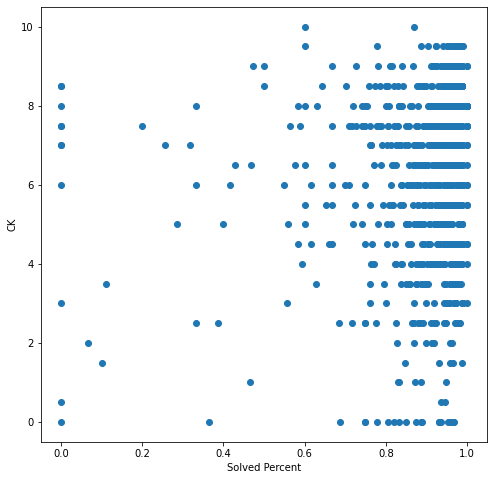

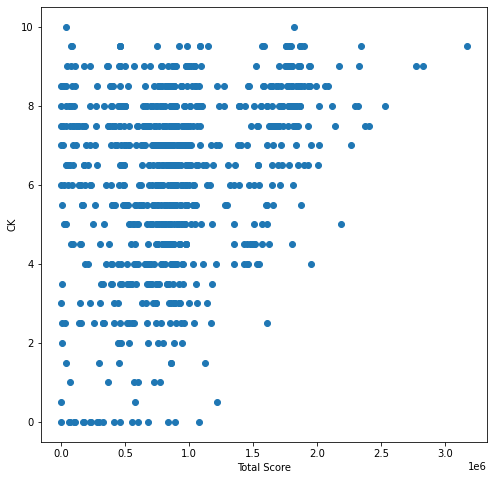

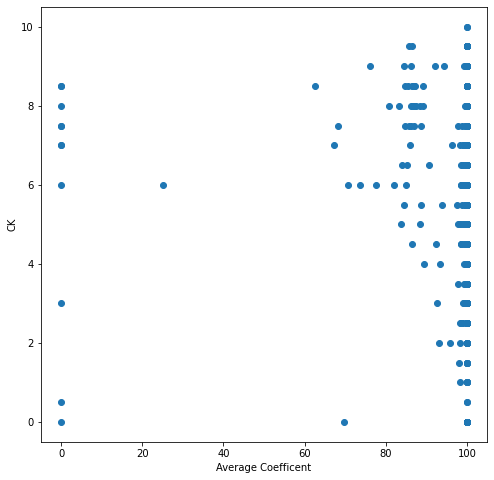

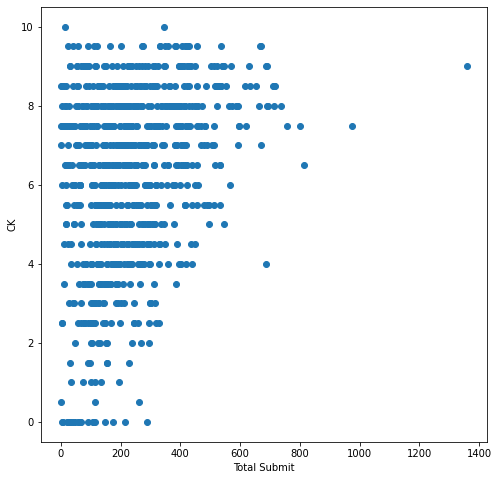

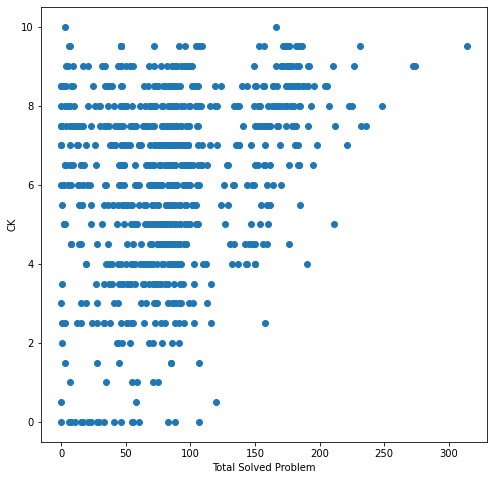

In [ ]:
dataPlot = []

# Xét phần trăm hoàn thành problem
x = np.array(trainData['Solved_Percent']).astype('float32')
y = np.array(trainData['CK']).astype('float32')
dataPlot.append([x,y, 'Solved Percent'])

# Xét tổng điểm
x = np.array(trainData['Total_Score']).astype('float32')
y = np.array(trainData['CK']).astype('float32')
dataPlot.append([x,y, 'Total Score'])

# Xét coeffience trung bình
x = np.array(trainData['Average_Coef']).astype('float32')
y = np.array(trainData['CK']).astype('float32')
dataPlot.append([x,y, 'Average Coefficent'])

# Xét tổng submit
x = np.array(trainData['Total_Submit']).astype('float32')
y = np.array(trainData['CK']).astype('float32')
dataPlot.append([x,y, 'Total Submit'])

# Xét tổng problem đã giải ra
x = np.array(trainData['Problem_Solved']).astype('float32')
y = np.array(trainData['CK']).astype('float32')
dataPlot.append([x,y, 'Total Solved Problem'])

drawPlotNormal(dataPlot)

**Nhận xét**

- Các data nhóm dùng để quan sát gồm: 
1.   Total Score (Tổng sổ điểm của sinh viên cho 1 problem, chỉ tính cho 1 bài)
2.   Solved Percent (Phần trăm số bài hoàn thành trên số bài đã thử)
3.   Average Coefficent (Hệ số nộp bài trễ trung bình, chỉ tính cho những bài làm đúng, nếu không có bài nào thì tự động cho 0)
4.   Total Submit (Tổng số lần submit của sinh viên trong wecode)
5.   Total Solved Problem (Tổng số bài đã giải ra trong wecode)

- Khi dùng các thông số trên để quan sát, nhóm thấy rằng data Total Score, Total Submit và Total Solved Problem có một pattern là những sinh viên nào làm bài càng nhiều, càng chăm chỉ thì khả năng sinh viên đó bị điểm thấp càng ít. Nhưng với hướng ngược lại thì điểm CK của sinh viên hoàn toàn ngẫu nhiên.

- Còn các thông số Solved Percent và Average Coefficent không liên quan đến điểm cuối kì, do trong plot nhóm thấy rằng dù cho sinh viên có giải đúng và nộp đúng hạn thì điểm số của sinh viên vẫn phân tán ngẫu nhiên.

**Hướng đi tương lai**

- Hiện tại Total Score, Total Submit và Total Solved Problem chỉ có nói được rằng sinh viên làm bài càng nhiều thì khả năng bị điểm thấp càng ít, còn hướng ngước lại thì vẫn không xác định được. 
- Vì thế dự kiến nhóm sẽ thử dùng thêm cột thời gian nộp bài đầu tiên và thời gian nộp bài cuối cùng để xem coi có thể giải quyết được vấn đề trên hay không.